# SUPERMOCK SYNTHETIC SKY CATALOG 
### Based on: 
- LastJourney Dark matter simulation products
- Semi-empirical modeling for dust, metallicity
- Heuristic modeling for galaxy-halo connection
- Stellar population synthesis


### Contains 
- RA-Dec coordinates, redshifts, velocities
- Simulation quantities such as star formation histories
- SEDs, Bandpasses from multiple surveys (SPHEREx, SDSS, COSMOS...) etc.

## Base simulation: HACC Gravity-only Simulation LastJourney: [[Paper]](https://arxiv.org/pdf/2006.01697.pdf)

| Cosmology Parameters | | Simulation Volume Parameters |
|----------------------|-|------------------------------|
| $$\Omega_m = 0.30964$$ | | $$L = 3400 \; h^{-1}\mathrm{Mpc}$$ |
| $$\Omega_b = 0.04897$$ | | $$N_P = 10752$$ |
| $$\Omega_\Lambda = 0.69036$$ | | $$m_p = 2.7174e+09 \; h^{-1}M_\odot$$ |
| $$\sigma_8 = 0.8102$$ | | $$z_\mathrm{start} = 200.0$$ |
| $$w = âˆ’1$$ | | $$n_\mathrm{steps} = 500$$ |

### Important feature
This catalog is Downsampled by 1000:1, i.e., one in every 1000 galaxy is shown. In addition, some of the lightcone files are missing. 

In [1]:
# import h5py
import numpy as np
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import pandas as pd
from mpl_toolkits.basemap import Basemap
# plt.style.use('dark_background')
from astropy import units as u
from astropy.coordinates import SkyCoord
import glob 

colorList = np.array(list(mcolors.TABLEAU_COLORS.items()))[:, 1]

In [2]:
from load_supermock import *
from sample_analysis_utils import *

#### Download the catalog from https://portal.nersc.gov/project/hacc/spherex_sky/DownsampledSuperMock/
#### (or directly from NERSC-Perlmutter:/global/cfs/cdirs/hacc/www/spherex_sky/DownsampledSuperMock, if you have access)

# **Catalog entries**

---

#### Mock observation catalog entries

- **galaxy_id**: *Galaxy ID*
- **ra_true**: *Right ascension coordinates of the galaxies on the full sky*
- **dec_true**: *Declination coordinates of the galaxies on the full sky*
- **redshift_true**: *Redshift of the galaxies*
- **SED**: *Spectral energy distributions in [Jy]*
- **SED_wavelength**: *Wavelength of the spectra in [A]*
- **mag_\<n\>_spherex**: *SPHEREx bandpasses in n:0-101*
- **mag_\<n\>_cosmos**: *COSMOS magnitudes in n:0-30*
- **mag_\<x\>_lsst**: *LSST magnitudes for x: {u, g, r, i, z, Y}*
- **mag_\<n\>_wise**: *WISE magnitudes in n:0-6*
- **mag_\<n\>_mass2**: *MASS2 magnitudes in n:0-2*
- **mag_\<n\>_ls**: *DECam Legacy Survey magnitudes in n:0-7*
- **mag_\<n\>_f784**: *f784 magnitude*


#### Simulation-only entries


- **halo_mass**: *Total mass of the host halo in [Msun/h]*
- **stellar_mass**: *Stellar mass of the galaxy in [Msun/h]*
- **position_x**: *co-moving coordinate (x) of the host core in [Mpc/h]*
- **position_y**: *co-moving coordinate (y) of the host core in [Mpc/h]*
- **position_z**: *co-moving coordinate (z) of the host core in [Mpc/h]*
- **velocity_x**: *co-moving velocity (x) of the host core in [km/s]*
- **velocity_y**: *co-moving velocity (y) of the host core in [km/s]*
- **velocity_z**: *co-moving velocity (z) of the host core in [km/s]*
- **is_central**: *Type of the host core: Central=1, Satellite=0*
- **SFH**: *Star formation history of the galaxy*
- **time_bins_SFH**: *Time bins for the SFH in [Gyr]*
- **halo_id**: *Host core ID*


## Listing all the available catalog files

In [3]:
all_available_catalog_files = sorted(glob.glob('Downsampled_SuperMocks/*.hdf5'), key=extract_core_number)
print('Available catalog files\n' + 10*'==')
print(*all_available_catalog_files, sep='\n')

Available catalog files
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_0_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_1_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_2_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_3_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_4_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_5_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_6_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_7_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_8_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_9_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_10_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_11_every_1000.hdf5
Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_12_e

## Reading catalog files -- reading single file

### Reading all attributes from the catalog
#### Also performing simple selections (such as removing invalid magnitude values)

In [4]:
# Testing the updated function on the provided file
catalog_name = all_available_catalog_files[3]
print(catalog_name)
Vol = 5025**3
test_data_single, removed_test_data_single, test_items_single = load_and_clean_single_catalog(fileIn = catalog_name)

Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_3_every_1000.hdf5
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_3_every_1000.hdf5
Total number of original galaxies: 7128
Total number of cleaned galaxies: 4253
Total number of removed galaxies: 2875
=--==--==--==--==--==--==--==--==--==--=


#### Features of the SuperMock catalog files

- ##### The catalogs files do not randomly sample the entire sky. 
- ##### Instead they sample either parts of the RA-dec-redshift space (for instance, load core: 180 or core: 181)
- ##### This coverage depends entirely on how the core histories intersect with the lightcones.

## Reading catalog files -- reading multiple files

#### This can be slow and memory intensive. 


In [5]:
# test_data, test_items = load_all_available_catalogs(dirIn = 'SuperMocks/', exclude_core_files_numbers = [180, 181, 182])
test_data, test_items = load_all_available_catalogs(dirIn = 'Downsampled_SuperMocks/') # Read all the available files

Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_0_every_1000.hdf5
Total number of original galaxies: 7169
Total number of cleaned galaxies: 4257
Total number of removed galaxies: 2912
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_1_every_1000.hdf5
Total number of original galaxies: 7062
Total number of cleaned galaxies: 3966
Total number of removed galaxies: 3096
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_2_every_1000.hdf5
Total number of original galaxies: 7005
Total number of cleaned galaxies: 3943
Total number of removed galaxies: 3062
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_3_every_1000.hdf5
Total number of original galaxies: 7128
Total number of cleaned galaxies: 4253
Total number of removed galaxies: 2875
=--==--==--==--==--==--==--==--==--==--=
Catalog: Downsampled_Sup

In [6]:
catalog_name

'Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_3_every_1000.hdf5'

In [7]:
catalog_name = 'SuperMock_v4_limited_sampling'
catalog_name = all_available_catalog_files[15]

# test_data, removed_test_data, test_items = load_and_clean_single_catalog(fileIn = catalog_name)

### Accessing desired catalog entries

In [8]:
ra_full = np.array(test_data['ra_true'])
dec_full = np.array(test_data['dec_true'])
redshift = np.array(test_data['redshift_true'])
halo_mass = np.array(test_data['halo_mass'])
stellar_mass = np.array(test_data['stellar_mass'])
is_central = np.array(test_data['is_central'])

wavelength = np.array(test_data['SED_wavelength']) #this is rest frame wavelength
SEDs = np.array(test_data['SED'])
luminosity = np.array(test_data['luminosity']) #incorrect calculation

mag_u = np.array(test_data['mag_u_sdss'])
mag_g = np.array(test_data['mag_g_sdss'])
mag_r = np.array(test_data['mag_r_sdss'])
mag_i = np.array(test_data['mag_i_sdss'])
mag_z = np.array(test_data['mag_z_sdss'])
mag_Y = np.array(test_data['mag_Y_sdss'])

## Sample analyses using the catalog

### 1. Sky distribution using the mollweide projection

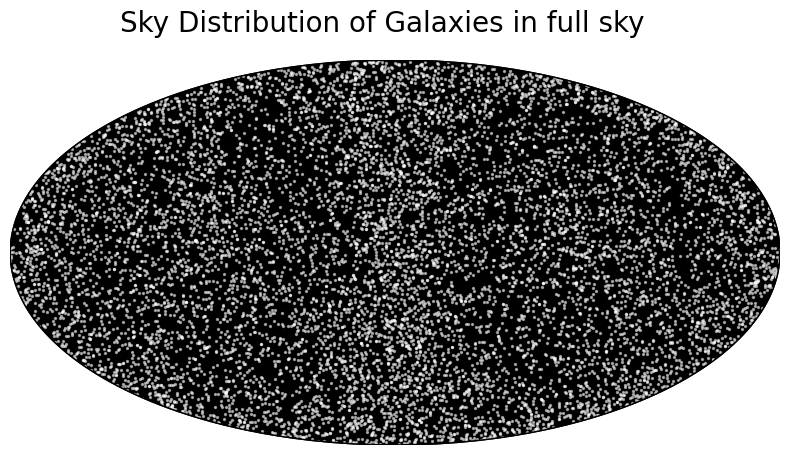

In [9]:
fig = plt.figure(figsize=(10, 5))

##########################
ax = fig.add_subplot(111)

# Only plotting random 10,000 galaxies
n_gal = 10000
random_gal_indices = np.random.randint(low=0, high=ra_full.shape[0], size=n_gal)

ra_octant = np.array(test_data['ra_true'][random_gal_indices])
dec_octant = np.array(test_data['dec_true'][random_gal_indices])

# Define the orthographic projection centered on the equator and prime meridian
m = Basemap(projection='moll', lat_0=-60, lon_0=90, resolution='c')
# Convert RA, Dec to x, y coordinates for plotting
x, y = m(ra_octant, dec_octant)

# Plot the sky distribution
m.scatter(x, y, s=2, c='white', alpha=0.5, edgecolors='w', linewidth=1)

# Draw parallels and meridians
# m.drawparallels(np.arange(-90.,90.,22.5), color='yellow', textcolor='yellow', linewidth=2)
# m.drawmeridians(np.arange(0.,360.,22.5), color='yellow', textcolor='yellow', linewidth=2)
m.drawmapboundary(fill_color='black')
# m.drawcoastlines(color='black', linewidth=0.5)
 
plt.suptitle('Sky Distribution of Galaxies in full sky', fontsize=20)
plt.show()

### 2. Halo mass function, stellar mass function and Stellar mass-to-halo mass relationship

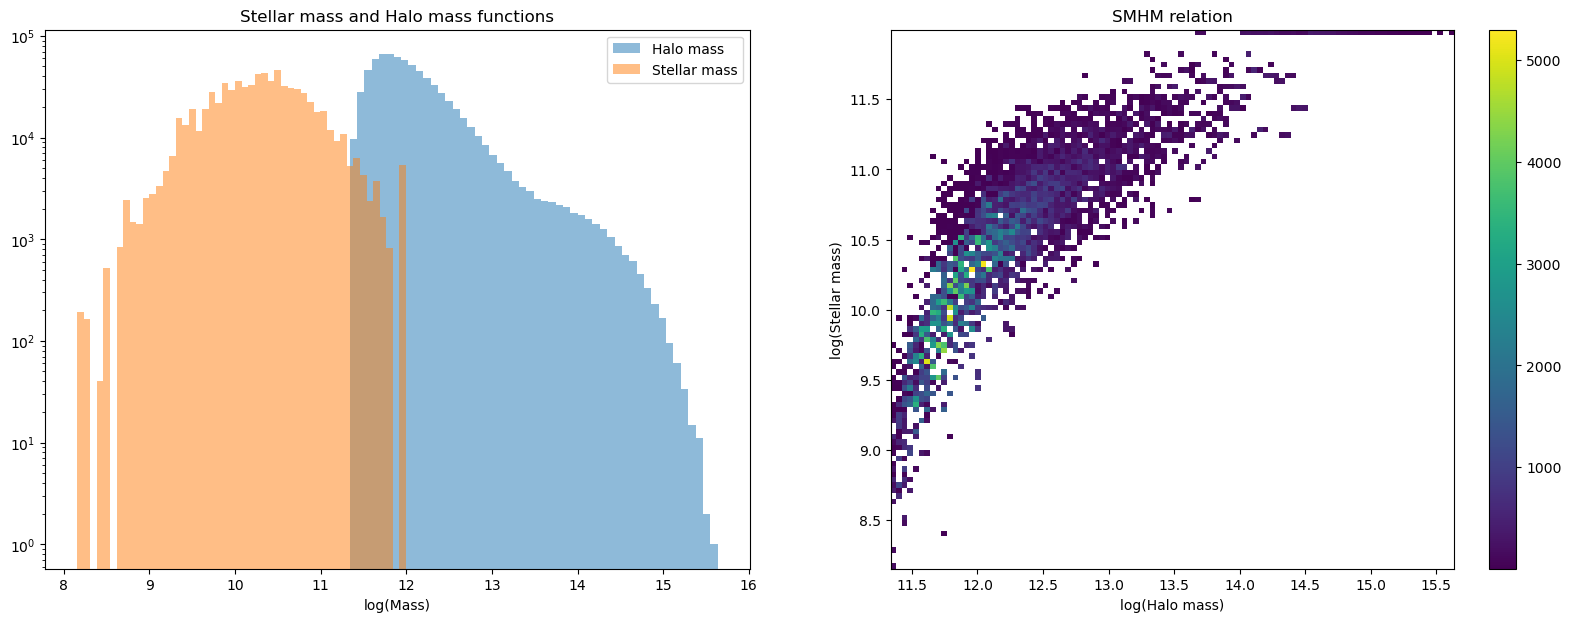

In [10]:
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121)

ax.set_title('Stellar mass and Halo mass functions')
ax.hist(np.log10(halo_mass), bins=50, alpha=0.5, label='Halo mass');
ax.hist(np.log10(stellar_mass), bins=50, alpha=0.5, label='Stellar mass');
ax.set_yscale('log')
ax.set_xlabel('log(Mass)')
ax.legend()

ax = fig.add_subplot(122)
_, _, _, im = ax.hist2d(np.log10(halo_mass), np.log10(stellar_mass), bins=(100, 100), cmin = 1)

ax.set_title('SMHM relation')
ax.set_xlabel('log(Halo mass)')
ax.set_ylabel('log(Stellar mass)')
plt.colorbar(im)

plt.show()

In [15]:
import corner
def plot_SMHM_comparison(Mpeak, Mstar, plt_title):
    plt.clf()
    plt.close('all')
    
    # SMHM
    behroozi = np.loadtxt('/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/data/mstar_mhalo/Behroozi2012.txt', delimiter=',')
    moster = np.loadtxt('/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/MAH/data/mstar_mhalo/Moster2013.txt', delimiter=',')

    plt.figure(32, figsize=(9,6))
    
    h = 1.0

    corner.hist2d( x=np.log10(Mpeak), 
                   y=np.log10(Mstar), 
                          bins=30, 
                          smooth=1.0,
                          new_fig=False, 
                          labels = 'Synthetic', 
                          color = 'r', 
                          fill_contours=True, 
                          levels=(0.95, 0.85, 0.75,),
                          alpha=(0.1, 0.2, 0.3, 0.4, ),
                          plot_density=True, 
                          plot_contours=True,
                          data_kwargs = {"ms":1, "alpha":0.6}
                          )

    plt.plot(behroozi[:, 0]*h, behroozi[:, 1]*h, lw =2, ls='dashed', color='g', label='Behroozi 2012')
    plt.plot(moster[:, 0]*h, moster[:, 1]*h, lw=2, ls='dashed', color='b', label='Moster 2013')

    # plt.xscale('log')
    # plt.yscale('log')

    plt.xlim(11.1, 13)
    plt.ylim(8.2, 11.7)
    plt.xlabel(r'$log(M_{peak})$', fontsize=18)
    plt.ylabel(r'$log(M_{star})$', fontsize=18)
    plt.legend(title='SMHM relation')#, bbox_to_anchor=(1.05, 1.0), loc='upper left')
    plt.title('Stellar Mass to Halo Mass relationship - '+ plt_title, fontsize=18)
    plt.show()
    # plt.savefig('plots/smhm_'+plt_title+'.png', bbox_inches='tight')

In [17]:
#plot_SMHM_comparison(halo_mass, stellar_mass, 'SuperMock')

### 3. SEDs of randomly chosen galaxies

Text(0.5, 1.0, 'Narrow band SEDs of a few galaxies')

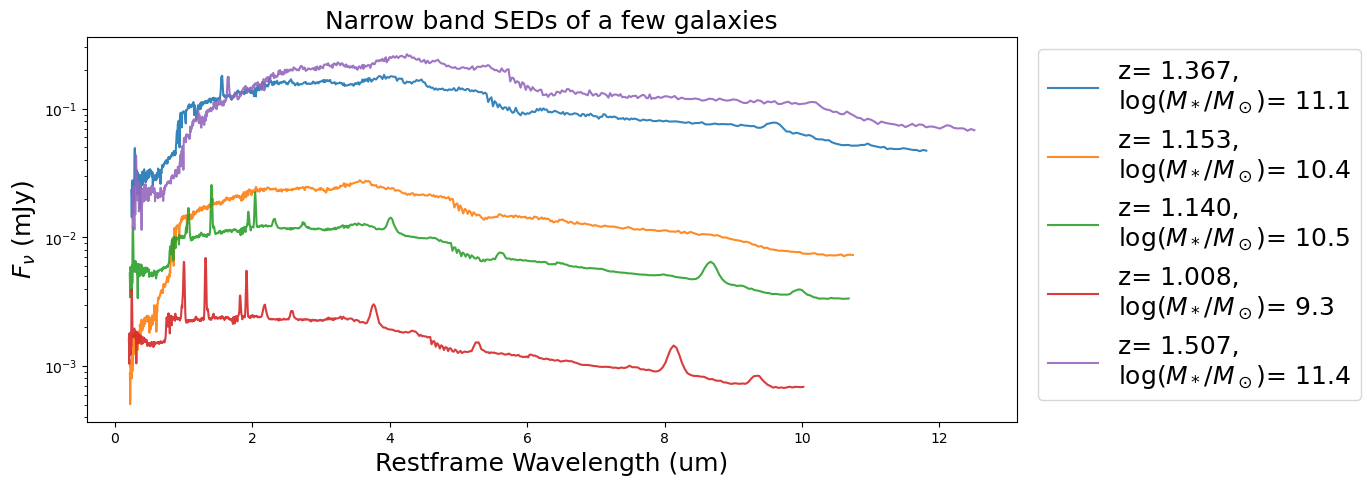

In [11]:
np.random.seed(2)
galID_arr = np.random.randint(low=0, high=SEDs.shape[0], size=5)

plt.figure(figsize=(12, 5))

for idx, galID in enumerate(galID_arr):    
    
    obs_frame_wave = wavelength*(1 + redshift[galID])
    plt.plot(obs_frame_wave/1e4 , 
             SEDs[galID]*1e3, 
             label='z= %.3f, \nlog($M_*/M_\odot$)= %.1f'%(redshift[galID], np.log10(stellar_mass[galID])), 
             color=colorList[idx],
             alpha=0.9);

plt.ylabel(r'$F_\nu$ (mJy)', fontsize=18)
plt.xlabel(' Restframe Wavelength (um) ', fontsize=18)
plt.yscale('log')
plt.legend(ncol=1, 
           # title='Redshift, Stellar Mass', 
           fontsize=18, bbox_to_anchor=(1.01, 1.0), 
           loc='upper left', title_fontsize=18)

plt.title('Narrow band SEDs of a few galaxies', fontsize=18)

### 4. Color-redshift relationship for Central galaxies (SDSS-r and SDSS-i bands)

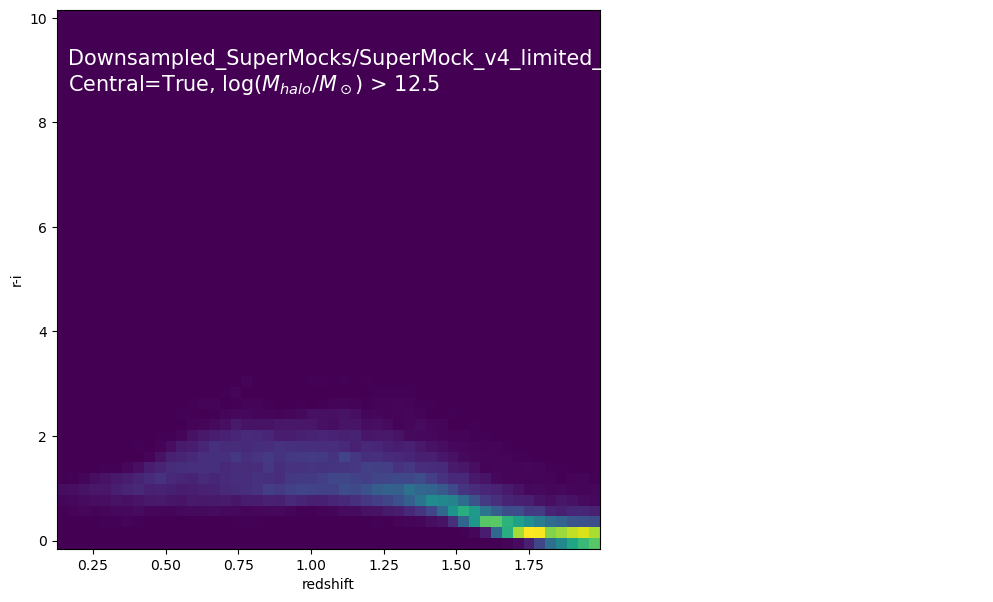

In [12]:
color_ri = mag_r - mag_i
mass_cut = 12.5
cond = np.where( (is_central==True) & ( np.log10(halo_mass) > mass_cut) ) 

redshift_select = redshift[cond]
ri_select = color_ri[cond]

f, ax = plt.subplots(1,1, figsize =(7, 7))
plt.hist2d(x=redshift_select, y=ri_select, bins=50);
plt.xlabel('redshift')
plt.ylabel('r-i')
plt.text(x=0.02, y=0.85, s='%s \nCentral=True, log($M_{halo}/M_\odot$) > %.1f'%(catalog_name, mass_cut), color='w', 
         transform=ax.transAxes, fontsize=15)
plt.show()

### 5. SDSS magnitude distributions

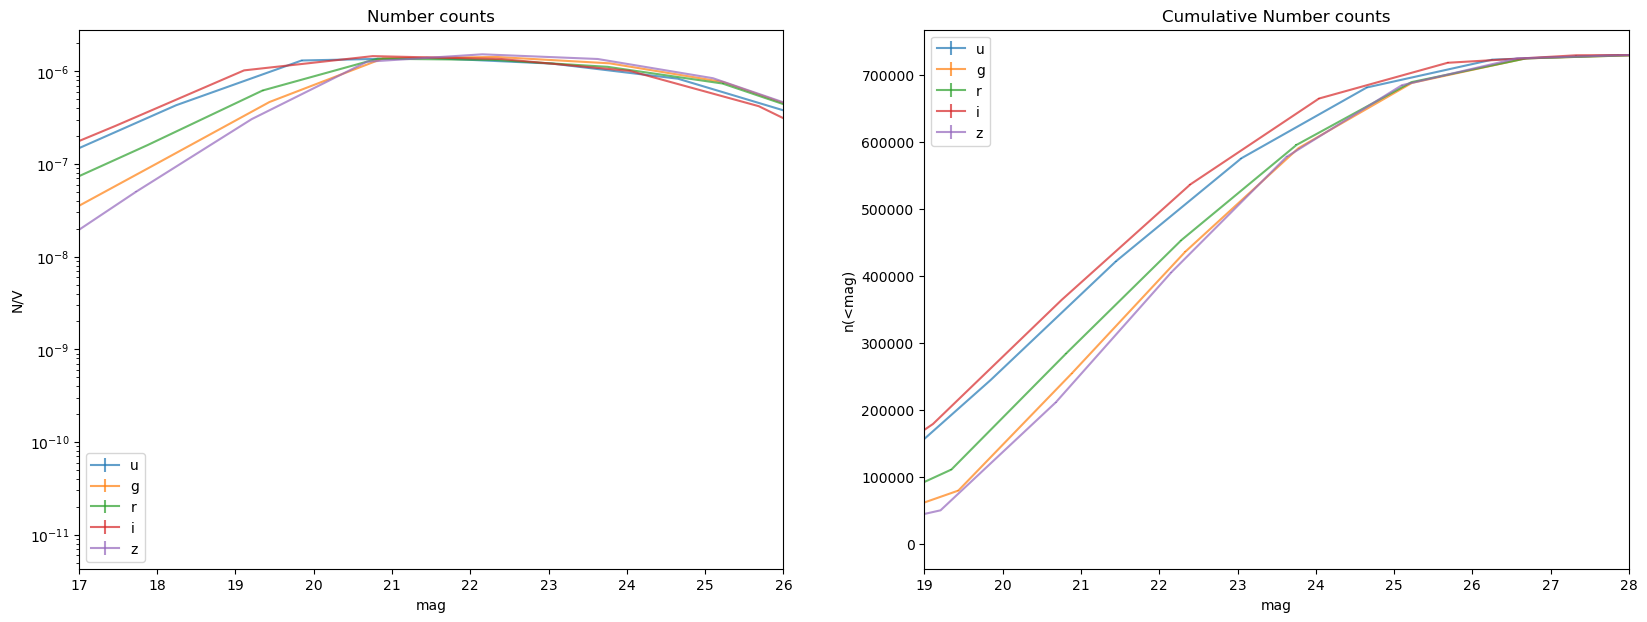

In [13]:
def plt_errorbar(x, label):
    y, bin_edges = np.histogram(x, bins = 50)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    plt.errorbar(bin_centers, y/Vol, yerr = (y**0.5)/Vol, label=label, alpha=0.7) 
    
def plt_cumulative(x, label):
    y, bin_edges = np.histogram(x, bins = 50)
    bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
    y_cumulative = np.cumsum(y)
    plt.errorbar(bin_centers, y_cumulative, yerr = (y_cumulative**0.5), label=label, alpha=0.7) 
    plt.xlim(19, 28)
    
    
fig = plt.figure(figsize=(20, 7))
ax = fig.add_subplot(121)


plt_errorbar(mag_u, 'u')
plt_errorbar(mag_g, 'g')
plt_errorbar(mag_r, 'r')
plt_errorbar(mag_i, 'i')
plt_errorbar(mag_z, 'z')
plt.title('Number counts')
plt.xlabel('mag')
plt.ylabel('N/V')
plt.xlim(17, 26)
# plt.ylim(1e-5, 1e-2)
plt.yscale('log')
plt.legend()


ax = fig.add_subplot(122)

# plt.figure(figsize=(9, 5))
plt_cumulative(mag_u, 'u')
plt_cumulative(mag_g, 'g')
plt_cumulative(mag_r, 'r')
plt_cumulative(mag_i, 'i')
plt_cumulative(mag_z, 'z')
plt.title('Cumulative Number counts')
plt.xlabel('mag')
plt.ylabel('n(<mag)')
plt.xlim(19, 28)
plt.legend()

In [21]:
df_train = pd.DataFrame()

# Add columns
df_train['u-g'] = (mag_u - mag_g)[redshift < 1]
df_train['g-r'] = (mag_g - mag_r)[redshift < 1]
df_train['r-i'] = (mag_r - mag_i)[redshift < 1]
df_train['i-z'] = (mag_i - mag_z)[redshift < 1]
df_train['mag(i)'] = (mag_i)[redshift < 1]
df_train['redshift'] = (redshift)[redshift < 1]

In [22]:
load_obs = True

def minmax_cuts(X, y):
    print(X.shape)
    min_col = -10
    max_col = 10
    min_mag = 10
    max_mag = 30
    min_z = 0
    max_z = 2.0
    
    print(X.shape)
    mask_cond =  np.where( 
        (X[:, 0] < max_col) & (X[:, 0] > min_col) &
        (X[:, 1] < max_col) & (X[:, 1] > min_col) &
        (X[:, 2] < max_col) & (X[:, 2] > min_col) &
        (X[:, 3] < max_col) & (X[:, 3] > min_col) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    
    print( np.array(mask_cond).shape)

    X_new = X[mask_cond]
    y_new = y[mask_cond]
    print(X_new.shape)
    return X_new, y_new


if load_obs:
    path_program = '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/phoZ/Data/fromGalaxev/photozs/datasets/'
    num_data = 10000
    ##################################################

    TestSDSS = True
    if TestSDSS:

        fileIn_col = path_program + 'Training_data_UM_random/SDSS_col_val.npy'
        fileIn_z = path_program + 'Training_data_UM_random/SDSS_zz_val.npy'
        
        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)
        
        Testfiles1 = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

        X_testSDSS = Testfiles1[:, 1:]  # color mag
        y_testSDSS = Testfiles1[:, 0] # spec z
        
    ############################################################
    ############## THINGS ARE SAME AFTER THIS ###########     

    TestDEEP2 = True
    if TestDEEP2:

        fileIn_col = path_program + 'data_march_2020/DEEP2_updated_colors_new.npy'
        fileIn_z = path_program + 'data_march_2020/DEEP2_updated_zz_new.npy'
        
        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z)
        
        Testfiles2 = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

        X_testDEEP2 = Testfiles2[:, 1:]  # color mag
        y_testDEEP2 = Testfiles2[:, 0] # spec z
    

    ############################################################

    TestCOSMOS = True
    if TestCOSMOS:

        fileIn_col = path_program + 'data_march_2020/COSMOS_updated_SDSScolors.npy'
        fileIn_z = path_program + 'data_march_2020/COSMOS_updated_SDSSzz.npy'
        

        TestfilesColors = np.load(fileIn_col)
        Testfiles_z = np.load(fileIn_z, allow_pickle=True).item()['zspec']
        
        Testfiles3 = np.append(Testfiles_z[:, None], TestfilesColors, axis=1)

        X_testCOSMOS = Testfiles3[:, 1:]  # color mag
        y_testCOSMOS = Testfiles3[:, 0] # spec z
    

    ############################################################
    
    X_testSDSS, y_testSDSS = minmax_cuts(X_testSDSS, y_testSDSS)
    X_testDEEP2, y_testDEEP2 = minmax_cuts(X_testDEEP2, y_testDEEP2)
    X_testCOSMOS, y_testCOSMOS = minmax_cuts(X_testCOSMOS, y_testCOSMOS)
    
    df_testSDSS = pd.DataFrame()

    # Add columns
    df_testSDSS['u-g'] = X_testSDSS[:num_data, 0]
    df_testSDSS['g-r'] = X_testSDSS[:num_data, 1]
    df_testSDSS['r-i'] = X_testSDSS[:num_data, 2]
    df_testSDSS['i-z'] = X_testSDSS[:num_data, 3]
    df_testSDSS['mag(i)'] = X_testSDSS[:num_data, 4]
    df_testSDSS['redshift'] = y_testSDSS[:num_data]

    df_testDEEP2 = pd.DataFrame()

    # Add columns
    df_testDEEP2['u-g'] = X_testDEEP2[:num_data, 0]
    df_testDEEP2['g-r'] = X_testDEEP2[:num_data, 1]
    df_testDEEP2['r-i'] = X_testDEEP2[:num_data, 2]
    df_testDEEP2['i-z'] = X_testDEEP2[:num_data, 3]
    df_testDEEP2['mag(i)'] = X_testDEEP2[:num_data, 4]
    df_testDEEP2['redshift'] = y_testDEEP2[:num_data]

    df_testCOSMOS = pd.DataFrame()

    # Add columns
    df_testCOSMOS['u-g'] = X_testCOSMOS[:num_data, 0]
    df_testCOSMOS['g-r'] = X_testCOSMOS[:num_data, 1]
    df_testCOSMOS['r-i'] = X_testCOSMOS[:num_data, 2]
    df_testCOSMOS['i-z'] = X_testCOSMOS[:num_data, 3]
    df_testCOSMOS['mag(i)'] = X_testCOSMOS[:num_data, 4]
    df_testCOSMOS['redshift'] = y_testCOSMOS[:num_data]

FileNotFoundError: [Errno 2] No such file or directory: '/lcrc/project/cosmo_ai/nramachandra/Projects/SPHEREx/phoZ/Data/fromGalaxev/photozs/datasets/Training_data_UM_random/SDSS_col_val.npy'

In [23]:
from getdist import plots, MCSamples
# plt.style.use('light_background')


allLabels = ['u-g', 'g-i', 'i-r', 'r-z', 'mag(i)', 'redshift']
line_labels = ['Synthetic', 'SDSS', 'DEEP2', 'COSMOS']

s1 = df_train.values 
samples1 = MCSamples(samples=s1, names= allLabels , labels=allLabels, label = line_labels[0], 
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':2, 'smooth_scale_1D':2})

s2 = df_testSDSS.values 
samples2 = MCSamples(samples=s2, names= allLabels , labels=allLabels, label = line_labels[1],
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':2, 'smooth_scale_1D':2})

s3 = df_testDEEP2.values 
samples3 = MCSamples(samples=s3, names= allLabels , labels=allLabels, label = line_labels[2],
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':2, 'smooth_scale_1D':2})

s4 = df_testCOSMOS.values 
samples4 = MCSamples(samples=s4, names= allLabels , labels=allLabels, label = line_labels[3],
                     settings={'mult_bias_correction_order':1,'smooth_scale_2D':2, 'smooth_scale_1D':2})


g = plots.get_subplot_plotter(subplot_size=4)
g.settings.axes_fontsize=27
g.settings.axes_labelsize = 27
g.settings.legend_fontsize = 27
g.settings.fontsize = 27
g.settings.alpha_filled_add=0.6
# g.settings.title_limit_fontsize = 27
g.settings.solid_contour_palefactor = 0.5
g.settings.num_plot_contours = 3

g.triangle_plot([samples1, samples2, samples3, samples4], allLabels , filled=True, contour_lws=3) 
# g.triangle_plot([samples1, samples2, samples3], allLabels , filled=True, contour_lws=3) 

# g.export('plots/triangle_plot.png')

Removed no burn in


NameError: name 'df_testSDSS' is not defined

### 6. Color-redshift relationship for Central galaxies (SDSS-r and SDSS-i bands)

0.12586236000061035 1.9927361011505127


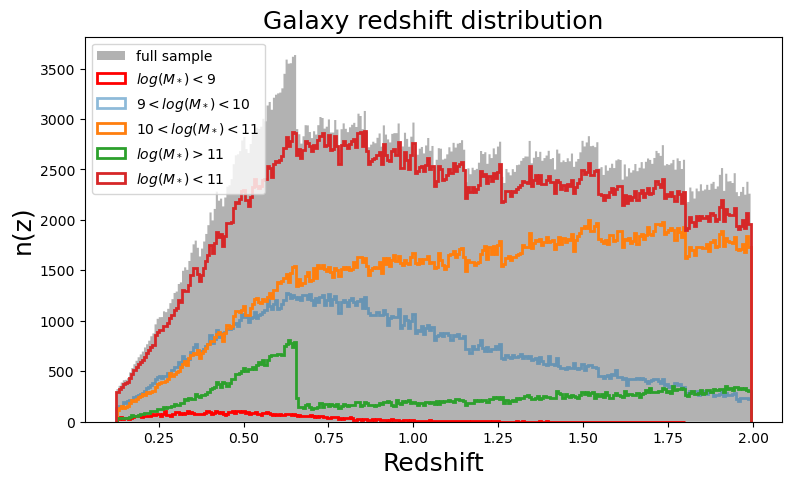

In [14]:
plt.figure(figsize=(9, 5))
nbins = 300
plt.hist( redshift, bins = nbins, label='full sample', alpha=0.3, color='k', histtype='stepfilled', lw=2);
plt.hist( redshift[np.where( np.log10(stellar_mass) < 9) ], bins = nbins, label=r'$log(M_*) < 9$', alpha=1, color='r', histtype='step', lw=2);
plt.hist( redshift[np.where( (np.log10(stellar_mass) > 9) & (np.log10(stellar_mass) < 10) )], bins = nbins, label=r'$9< log(M_*) < 10$', alpha=0.5, histtype='step', lw=2);
plt.hist( redshift[np.where( (np.log10(stellar_mass) > 10) & (np.log10(stellar_mass) < 11) ) ], bins = nbins, label=r'$10< log(M_*) < 11$', alpha=1, histtype='step', lw=2);
plt.hist( redshift[np.where( np.log10(stellar_mass) > 11) ], bins = nbins, label=r'$log(M_*) > 11$', alpha=1, histtype='step', lw=2);
plt.hist( redshift[np.where( np.log10(stellar_mass) < 11) ], bins = nbins, label=r'$log(M_*) < 11$', alpha=1, histtype='step', lw=2);
# plt.hist( redshift[np.where( np.log10(stellar_mass) < 11.5) ], bins = nbins, label=r'$log(M_*) < 11$', alpha=1, histtype='step', lw=2);


plt.title('Galaxy redshift distribution', fontsize=18)
plt.xlabel('Redshift', fontsize=18)
plt.ylabel('n(z)', fontsize=18)
# plt.xlim(0, 0.52)
plt.legend()
print(min(redshift), max(redshift))

0.12586236000061035 1.9927361011505127


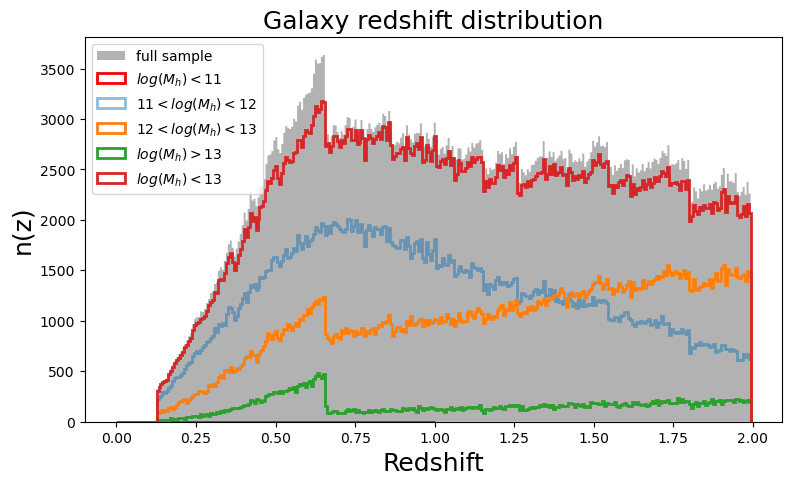

In [15]:
plt.figure(figsize=(9, 5))
nbins = 300
plt.hist( redshift, bins = nbins, label='full sample', alpha=0.3, color='k', histtype='stepfilled', lw=2);
plt.hist( redshift[np.where( np.log10(halo_mass) < 11) ], bins = nbins, label=r'$log(M_h) < 11$', alpha=1, color='r', histtype='step', lw=2);
plt.hist( redshift[np.where( (np.log10(halo_mass) > 11) & (np.log10(halo_mass) < 12) )], bins = nbins, label=r'$11< log(M_h) < 12$', alpha=0.5, histtype='step', lw=2);
plt.hist( redshift[np.where( (np.log10(halo_mass) > 12) & (np.log10(halo_mass) < 13) ) ], bins = nbins, label=r'$12< log(M_h) < 13$', alpha=1, histtype='step', lw=2);
plt.hist( redshift[np.where( np.log10(halo_mass) > 13) ], bins = nbins, label=r'$log(M_h) > 13$', alpha=1, histtype='step', lw=2);
plt.hist( redshift[np.where( np.log10(halo_mass) < 13) ], bins = nbins, label=r'$log(M_h) < 13$', alpha=1, histtype='step', lw=2);
# plt.hist( redshift[np.where( np.log10(stellar_mass) < 11.5) ], bins = nbins, label=r'$log(M_*) < 11$', alpha=1, histtype='step', lw=2);


plt.title('Galaxy redshift distribution', fontsize=18)
plt.xlabel('Redshift', fontsize=18)
plt.ylabel('n(z)', fontsize=18)
# plt.xlim(0, 0.52)
plt.legend()
print(min(redshift), max(redshift))

### 7. Galaxy stellar mass functions

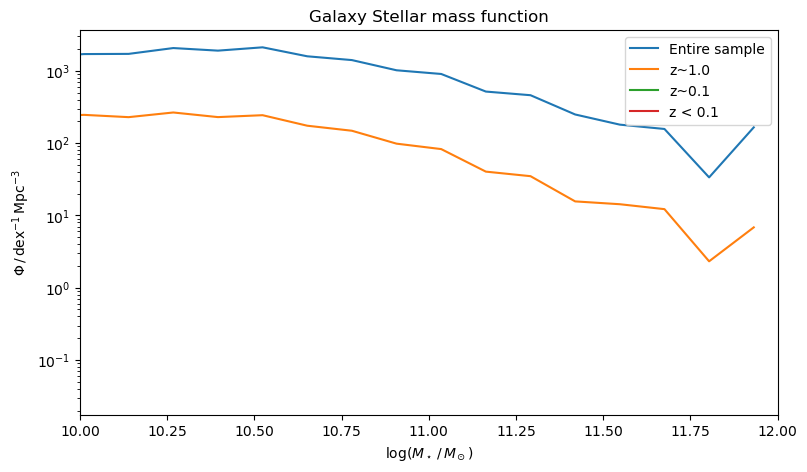

In [16]:
Max, Phi = GSMF(stellar_mass[stellar_mass > 9])
Max0_2, Phi0_2 = GSMF(stellar_mass[ (stellar_mass > 9)&(redshift < 1.1) &(redshift > 0.9)])
Max0_1, Phi0_1 = GSMF(stellar_mass[ (stellar_mass > 9)&(redshift < 0.11) &(redshift > 0.09)])
Max0_05, Phi0_05 = GSMF(stellar_mass[ (stellar_mass > 9)&(redshift < 0.1) &(redshift > 0.000)])


plt.figure(figsize=(9, 5))
plt.title('Galaxy Stellar mass function')
plt.yscale('log')
plt.xlabel(r'$\log(M_\star\,/\,M_\odot)$')
plt.ylabel(r'$\Phi\,/\,\mathrm{dex}^{-1}\,\mathrm{Mpc}^{-3}$')

plt.plot( Max, Phi , ls='-', label='Entire sample')
plt.plot( Max0_2, Phi0_2 , ls='-', label='z~1.0')
plt.plot( Max0_1, Phi0_1 , ls='-', label='z~0.1')
plt.plot( Max0_05, Phi0_05 , ls='-', label='z < 0.1')

plt.xlim(10, 12)

plt.legend()

### 8. Two-point correlation function (may not be accurate)

In [17]:
x_subset, y_subset, z_subset = radec_to_cartesian(ra_full, dec_full, redshift)
bin_centers, xi, xi_Landy_Szalay = xyz_to_xi(x_subset, y_subset, z_subset)

/home/joeadamo/Research/hacc-mocks/sample_analysis_utils.py:46: RuntimeWarning: divide by zero encountered in divide
  xi = DD / RR - 1
/home/joeadamo/Research/hacc-mocks/sample_analysis_utils.py:55: RuntimeWarning: divide by zero encountered in divide
  xi_Landy_Szalay = (DD - 2*DR + RR) / RR
/home/joeadamo/Research/hacc-mocks/sample_analysis_utils.py:55: RuntimeWarning: invalid value encountered in divide
  xi_Landy_Szalay = (DD - 2*DR + RR) / RR


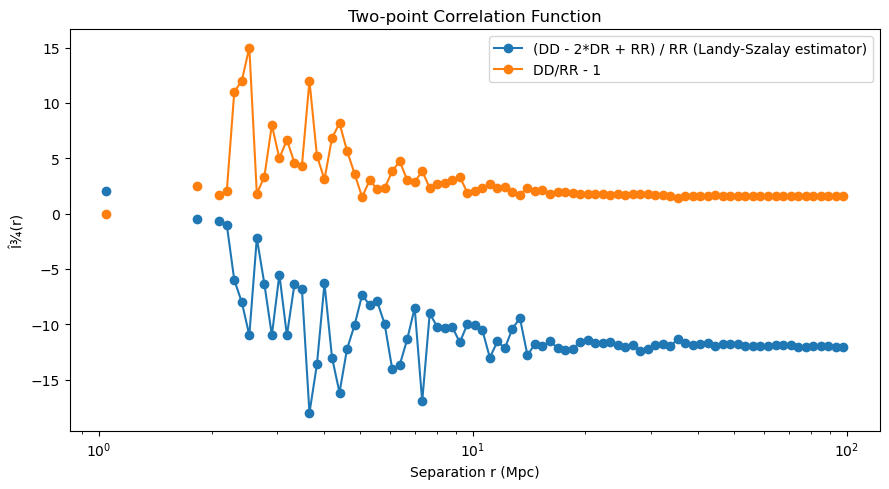

In [18]:
# Plot the two-point correlation function
plt.figure(figsize=(9, 5))
plt.plot(bin_centers, xi_Landy_Szalay, marker='o', linestyle='-', label='(DD - 2*DR + RR) / RR (Landy-Szalay estimator)')
plt.plot(bin_centers, xi, marker='o', linestyle='-', label='DD/RR - 1')

plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Separation r (Mpc)')
plt.ylabel('Î¾(r)')
plt.title('Two-point Correlation Function')
# plt.grid(True, which="both", ls="--")
plt.legend()
plt.tight_layout()
plt.show()

### We also provide auxilary pickle files for information about survey bandpasses

In [19]:
central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('SPHEREx', dirIn_bands='Bands/')

In [20]:
# central_wavelengths, bandpass_wavs, bandpass_vals, bandpass_names = load_survey_pickle('WISE', dirIn_bands='Bands/')

In [21]:
bandpass_names

['SPHEREx_band1_ch16',
 'SPHEREx_band1_ch14',
 'SPHEREx_band1_ch11',
 'SPHEREx_band1_ch12',
 'SPHEREx_band1_ch13',
 'SPHEREx_band1_ch9',
 'SPHEREx_band1_ch17',
 'SPHEREx_band1_ch5',
 'SPHEREx_band1_ch8',
 'SPHEREx_band1_ch7',
 'SPHEREx_band1_ch2',
 'SPHEREx_band1_ch15',
 'SPHEREx_band1_ch6',
 'SPHEREx_band1_ch4',
 'SPHEREx_band1_ch10',
 'SPHEREx_band1_ch1',
 'SPHEREx_band1_ch3',
 'SPHEREx_band2_ch8',
 'SPHEREx_band2_ch10',
 'SPHEREx_band2_ch12',
 'SPHEREx_band2_ch13',
 'SPHEREx_band2_ch15',
 'SPHEREx_band2_ch14',
 'SPHEREx_band2_ch9',
 'SPHEREx_band2_ch5',
 'SPHEREx_band2_ch1',
 'SPHEREx_band2_ch4',
 'SPHEREx_band2_ch7',
 'SPHEREx_band2_ch3',
 'SPHEREx_band2_ch2',
 'SPHEREx_band2_ch16',
 'SPHEREx_band2_ch11',
 'SPHEREx_band2_ch6',
 'SPHEREx_band2_ch17',
 'SPHEREx_band3_ch7',
 'SPHEREx_band3_ch6',
 'SPHEREx_band3_ch5',
 'SPHEREx_band3_ch3',
 'SPHEREx_band3_ch11',
 'SPHEREx_band3_ch15',
 'SPHEREx_band3_ch9',
 'SPHEREx_band3_ch1',
 'SPHEREx_band3_ch4',
 'SPHEREx_band3_ch16',
 'SPHEREx_ban

### 9. Reading spherex bandpasses, plotting number densities in (color vs redshift) plot 

In [22]:
mag_spherex_0 = np.array(test_data['mag_0_spherex'])
mag_spherex_1 = np.array(test_data['mag_1_spherex'])
mag_spherex_2 = np.array(test_data['mag_2_spherex'])
mag_spherex_3 = np.array(test_data['mag_3_spherex'])
mag_spherex_4 = np.array(test_data['mag_4_spherex'])
mag_spherex_5 = np.array(test_data['mag_5_spherex'])
mag_spherex_6 = np.array(test_data['mag_6_spherex'])
mag_spherex_7 = np.array(test_data['mag_7_spherex'])
mag_spherex_8 = np.array(test_data['mag_8_spherex'])

s1 = np.array([mag_spherex_0, mag_spherex_1, mag_spherex_2, mag_spherex_3, mag_spherex_4, mag_spherex_5, mag_spherex_6, mag_spherex_7, mag_spherex_8, redshift]).T
allLabels = [ 'Mag(' +str(i+1)+ ') - Mag(' +str(i)+ ')' for i in range(s1.shape[1] - 1)]

In [23]:
allLabels = ['Band:' +bandpass_names[i][12:13]+', Channel: ' +bandpass_names[i][16:]  for i in range(s1.shape[1] - 1)]

In [24]:
allLabels

['Band:1, Channel: 16',
 'Band:1, Channel: 14',
 'Band:1, Channel: 11',
 'Band:1, Channel: 12',
 'Band:1, Channel: 13',
 'Band:1, Channel: 9',
 'Band:1, Channel: 17',
 'Band:1, Channel: 5',
 'Band:1, Channel: 8']

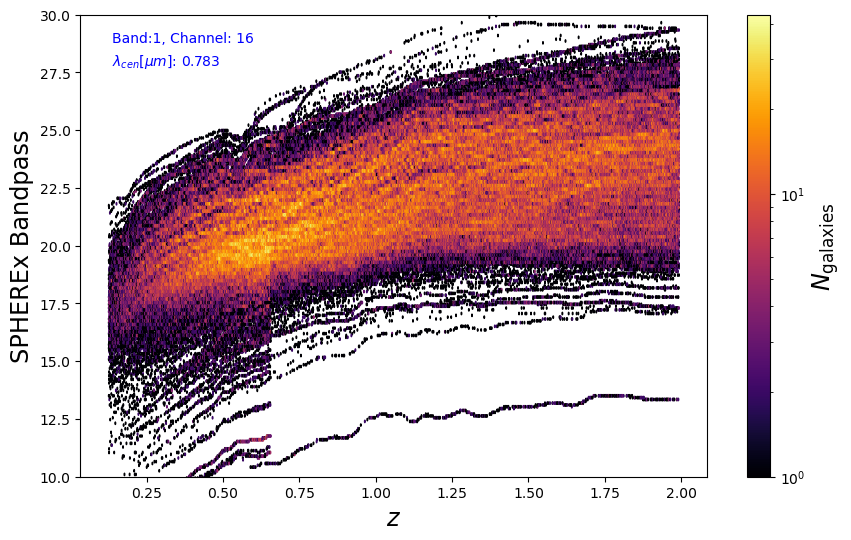

In [25]:
ncols = 1
nrows = 1

f, a = plt.subplots(ncols= ncols, nrows = nrows, sharex = True, figsize=(ncols*8, nrows*6))
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.01, right=0.99)

for col_idx in range(ncols):
    for row_idx in range(nrows):

        band_idx = row_idx*nrows + col_idx
        hb = a.hexbin(s1[:, -1], s1[:, band_idx], gridsize= 1000,  bins='log', cmap='inferno')
        a.set_xlabel(r'$z$', fontsize = "xx-large")
        a.set_ylabel('SPHEREx Bandpass', fontsize = "xx-large")
        a.text(0.05, 0.9, r'$\lambda_{cen} [\mu m]$: ' + str( round(central_wavelengths[band_idx], 3)),
               horizontalalignment='left', verticalalignment='center', transform=a.transAxes, c='blue')
        a.text(0.05, 0.95, allLabels[band_idx],
               horizontalalignment='left', verticalalignment='center', transform=a.transAxes, c='blue')

        cb = f.colorbar(hb, ax=a)
        cb.set_label(r'$N_{\rm galaxies}$', fontsize = "xx-large")
        a.set_ylim(10, 30)

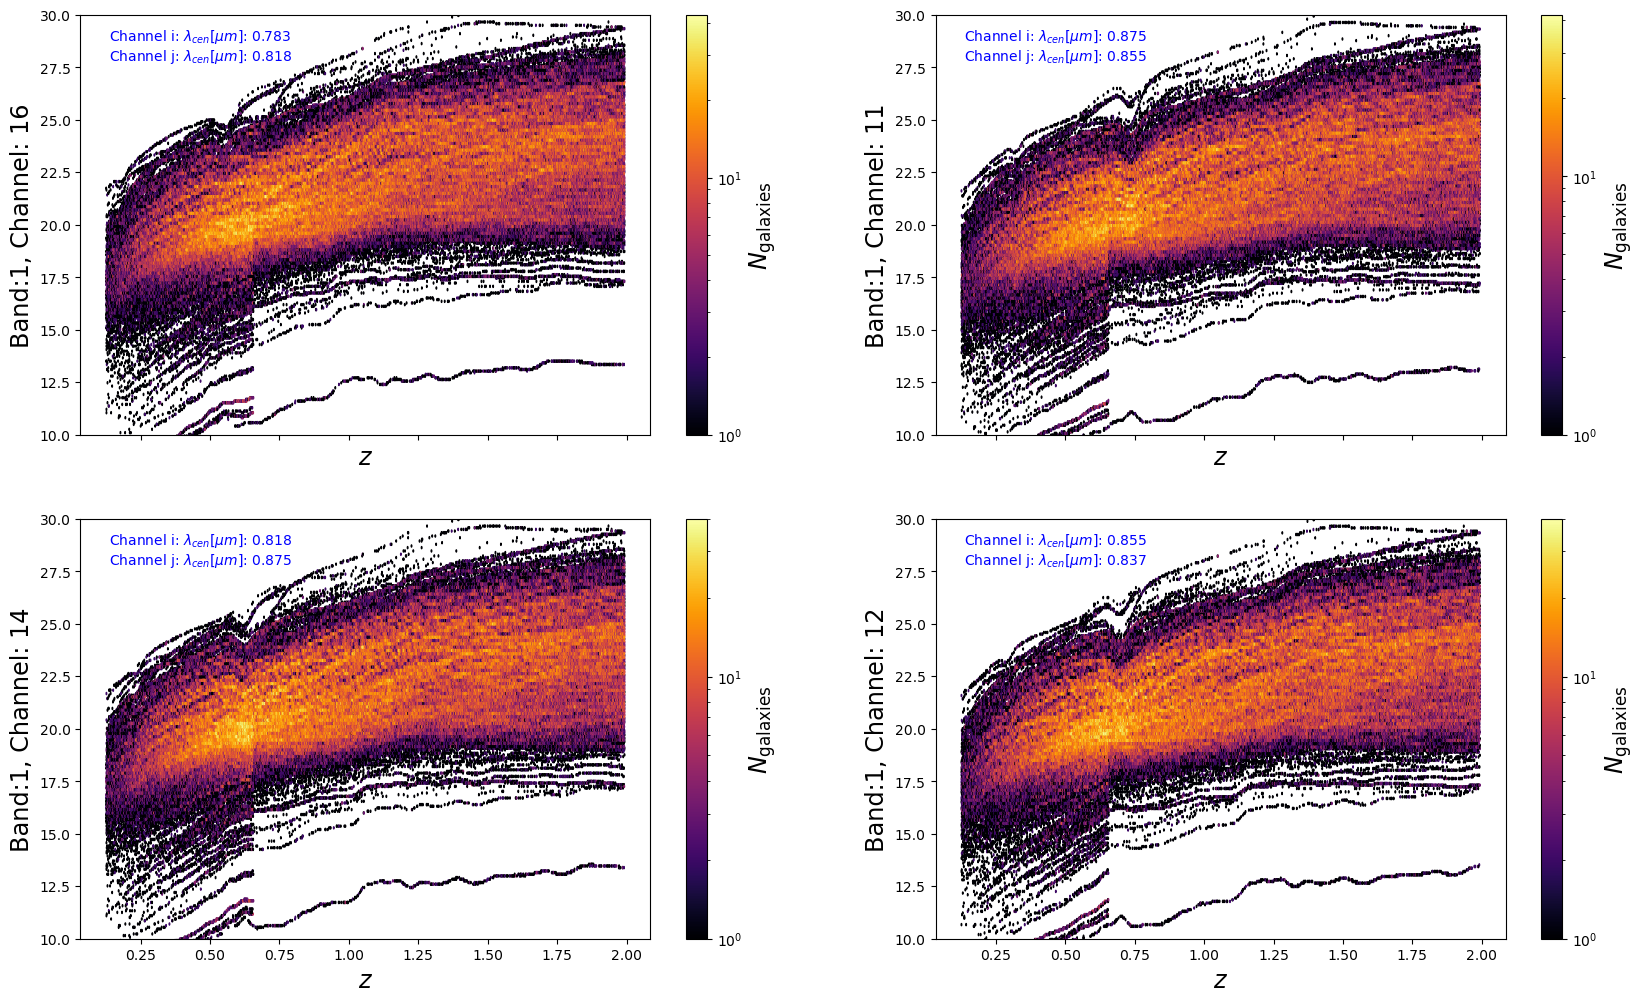

In [26]:
ncols = 2
nrows = 2

f, a = plt.subplots(ncols= ncols, nrows = nrows, sharex = True, figsize=(ncols*8, nrows*6))
f.subplots_adjust(hspace=0.2, wspace=0.2, left=0.01, right=0.99)

for col_idx in range(ncols):
    for row_idx in range(nrows):

        band_idx = row_idx*nrows + col_idx
        hb = a[col_idx, row_idx].hexbin(s1[:, -1], s1[:, band_idx], gridsize= 1000,  bins='log', cmap='inferno')
        a[col_idx, row_idx].set_xlabel(r'$z$', fontsize = "xx-large")
        a[col_idx, row_idx].set_ylabel(allLabels[band_idx], fontsize = "xx-large")
        #a[col_idx, row_idx].text(0.2, 0.9, allLabels[band_idx], horizontalalignment='left', verticalalignment='center', transform=a[col_idx, row_idx].transAxes, c='white')
        # a[col_idx, row_idx].text(0.05, 0.9, 'channel i (Âµm): ' + str(lambda_min[band_idx]) + ' -- ' + str(lambda_max[band_idx]) , horizontalalignment='left', verticalalignment='center', transform=a[col_idx, row_idx].transAxes, c='white')
        a[col_idx, row_idx].text(0.05, 0.95, 
                                 r'Channel i: $\lambda_{cen} [\mu m]$: ' 
                                 + str( round(central_wavelengths[band_idx], 3)),
                                 horizontalalignment='left', verticalalignment='center', transform=a[col_idx, row_idx].transAxes, c='blue')

        
        a[col_idx, row_idx].text(0.05, 0.9, 
                                 r'Channel j: $\lambda_{cen} [\mu m]$: ' 
                                 + str( round(central_wavelengths[band_idx + 1], 3)),
                                 horizontalalignment='left', verticalalignment='center', transform=a[col_idx, row_idx].transAxes, c='blue')
        #a[col_idx, row_idx].set(aspect='equal')
        cb = f.colorbar(hb, ax=a[col_idx, row_idx])
        cb.set_label(r'$N_{\rm galaxies}$', fontsize = "xx-large")
        a[col_idx, row_idx].set_ylim(10, 30)

In [27]:
# bins(M_star vs z)
# check spec, mean(spec)

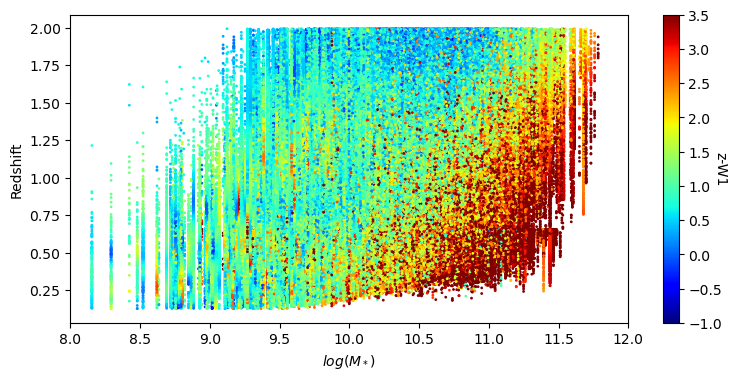

In [28]:
import matplotlib.cm as cm

selection = np.where(test_data["mag_i_sdss"] > 18)

# color = test_data["mag_z_sdss"] - test_data["mag_0_wise"] 
color = test_data["mag_z_sdss"] - test_data["mag_0_wise"] 

red = test_data['redshift_true']
m_star = np.array(test_data['stellar_mass'])

plt.figure(figsize=(9,4))
plt.scatter(np.log10(m_star[selection])[::], 
            red[selection][::], 
            c=color[selection][::], s=1, cmap="jet", vmin=-1, vmax=3.5)
plt.ylabel(r'Redshift')
plt.xlabel(r'$log(M_*)$')

plt.xlim(8 ,12)

#legend
cbar = plt.colorbar()
cbar.set_label('z-W1', rotation=270)

plt.show()

Catalog: Downsampled_SuperMocks/SuperMock_v4_limited_sampling_core_120_every_1000.hdf5
Total number of original galaxies: 7069
Total number of cleaned galaxies: 4182
Total number of removed galaxies: 2887
=--==--==--==--==--==--==--==--==--==--=


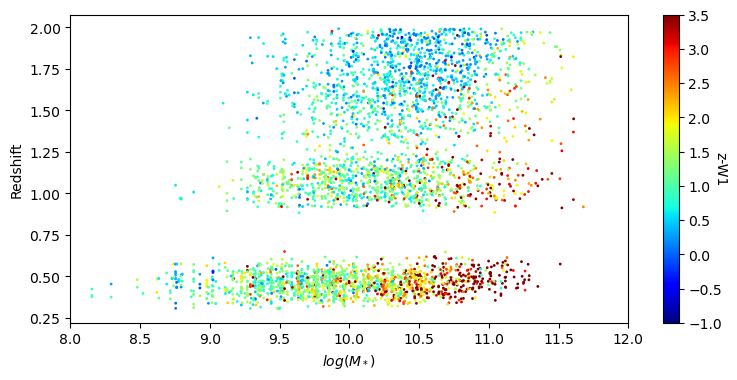

In [30]:
# Testing the updated function on the provided file
catalog_name = all_available_catalog_files[100]

Vol = 5025**3
test_data_single, removed_test_data_single, test_items_single = load_and_clean_single_catalog(fileIn = catalog_name)



selection = np.where(test_data_single["mag_i_sdss"] > 18)

# color = test_data["mag_z_sdss"] - test_data["mag_0_wise"] 
color = test_data_single["mag_z_sdss"] - test_data_single["mag_0_wise"] 

red = test_data_single['redshift_true']
m_star = np.array(test_data_single['stellar_mass'])

plt.figure(figsize=(9,4))
plt.scatter(np.log10(m_star[selection])[::], 
            red[selection][::], 
            c=color[selection][::], s=1, cmap="jet", vmin=-1, vmax=3.5)
plt.ylabel(r'Redshift')
plt.xlabel(r'$log(M_*)$')

plt.xlim(8 ,12)

#legend
cbar = plt.colorbar()
cbar.set_label('z-W1', rotation=270)

plt.show()